<a href="https://colab.research.google.com/github/talhaanwarch/my_pytorch/blob/master/advance/3D_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install "monai-weekly[nibabel]"
!pip install -U pytorch-lightning
!pip install torchmetrics
!pip install tqdm
%matplotlib inline

In [2]:
#download data
import os
if os.path.isfile('Task09_Spleen.tar') is False:
  !wget https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar

In [3]:
import tarfile
if os.path.isdir('Task09_Spleen') is False:
  my_tar = tarfile.open('/content/Task09_Spleen.tar')
  my_tar.extractall('/content/')
  my_tar.close()

In [4]:
from glob import glob
import os
images = sorted(glob("Task09_Spleen/imagesTr/*.nii.gz"))
segs = sorted(glob("Task09_Spleen/labelsTr/*.nii.gz"))
data_dicts = [
            {"image": image_name, "label": label_name}
            for image_name, label_name in zip(images, segs)
        ]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [5]:
import nibabel as nib
for i in range(len(train_files)):
  img = nib.load(train_files[i]['image'])
  lab = nib.load(train_files[i]['label'])
  print(img.shape,lab.shape)

(512, 512, 55) (512, 512, 55)
(512, 512, 168) (512, 512, 168)
(512, 512, 77) (512, 512, 77)
(512, 512, 54) (512, 512, 54)
(512, 512, 61) (512, 512, 61)
(512, 512, 95) (512, 512, 95)
(512, 512, 164) (512, 512, 164)
(512, 512, 51) (512, 512, 51)
(512, 512, 90) (512, 512, 90)
(512, 512, 168) (512, 512, 168)
(512, 512, 89) (512, 512, 89)
(512, 512, 148) (512, 512, 148)
(512, 512, 94) (512, 512, 94)
(512, 512, 87) (512, 512, 87)
(512, 512, 65) (512, 512, 65)
(512, 512, 119) (512, 512, 119)
(512, 512, 44) (512, 512, 44)
(512, 512, 103) (512, 512, 103)
(512, 512, 40) (512, 512, 40)
(512, 512, 56) (512, 512, 56)
(512, 512, 104) (512, 512, 104)
(512, 512, 83) (512, 512, 83)
(512, 512, 100) (512, 512, 100)
(512, 512, 93) (512, 512, 93)
(512, 512, 94) (512, 512, 94)
(512, 512, 92) (512, 512, 92)
(512, 512, 112) (512, 512, 112)
(512, 512, 99) (512, 512, 99)
(512, 512, 88) (512, 512, 88)
(512, 512, 61) (512, 512, 61)
(512, 512, 112) (512, 512, 112)
(512, 512, 156) (512, 512, 156)


In [19]:
import nibabel as nib
val_label_shape=[]
for i in range(len(val_files)):
  img = nib.load(val_files[i]['image'])
  lab = nib.load(val_files[i]['label'])
  val_label_shape.append(lab.shape)
  print(img.shape,lab.shape)

(512, 512, 33) (512, 512, 33)
(512, 512, 50) (512, 512, 50)
(512, 512, 135) (512, 512, 135)
(512, 512, 97) (512, 512, 97)
(512, 512, 101) (512, 512, 101)
(512, 512, 80) (512, 512, 80)
(512, 512, 60) (512, 512, 60)
(512, 512, 31) (512, 512, 31)
(512, 512, 41) (512, 512, 41)


In [12]:
from  monai import transforms as T
train_transforms = T.Compose(
            [
                T.LoadImaged(keys=["image", "label"]),
                T.AddChanneld(keys=["image", "label"]),
                T.Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                T.Orientationd(keys=["image", "label"], axcodes="RAS"),
                T.ScaleIntensityRanged(
                    keys=["image"], a_min=-57, a_max=164,
                    b_min=0.0, b_max=1.0, clip=True,
                ),
                T.Resized(keys=["image", "label"],spatial_size =(224,224,-1)),
                T.DivisiblePadd(keys=["image", "label"],k=(-1,-1,96)),
                # T.CropForegroundd(keys=["image", "label"], source_key="image"),
                
                T.ToTensord(keys=["image", "label"]),
            ]
        )
val_transforms =T. Compose(
    [
        T.LoadImaged(keys=["image", "label"]),
        T.AddChanneld(keys=["image", "label"]),
        T.Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        T.Orientationd(keys=["image", "label"], axcodes="RAS"),
        T.ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        T.Resized(keys=["image", "label"],spatial_size =(224,224,-1)),
        T.DivisiblePadd(keys=["image", "label"],k=(-1,-1,96)),
        #T.CropForegroundd(keys=["image", "label"], source_key="image"),
        T.ToTensord(keys=["image", "label"]),
    ]
)

In [13]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from monai.losses import DiceLoss
from torch.utils.data import DataLoader, Dataset
from monai.data import CacheDataset, list_data_collate
from pytorch_lightning.loggers import TensorBoardLogger
from monai.networks.nets import UNet
import torch.nn as nn
import torch
import torchmetrics


In [14]:
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference

class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer = UNet(
                      dimensions=3,
                      in_channels=1,
                      out_channels=2,
                      channels=(16, 32, 64, 128, 256),
                      strides=(2, 2, 2, 2),
                      num_res_units=2,
                      norm=Norm.BATCH,
                  )

  #parameters
    self.lr=1e-4
    self.batch_size=8
    self.numworker=1
    self.criterion=DiceLoss(to_onehot_y=True, softmax=True)
    self.metrics = torchmetrics.IoU(num_classes=2)
  def forward(self,x):
    return self.layer(x)


  def configure_optimizers(self):
    opt=torch.optim.Adam(self.parameters(), lr=self.lr)
    return opt

  def train_dataloader(self):
    ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0, num_workers=self.numworker)
    loader=DataLoader(ds, batch_size=1, shuffle=True,num_workers=self.numworker, collate_fn=list_data_collate)
    return loader

  def training_step(self,batch,batch_idx):
    image,segment=batch["image"], batch["label"]
    #print('train',' image',image.shape,'label',segment.shape)
    out=self(image)
    loss=self.criterion(out,segment)
    #print('train ','output',out.shape)

    self.log('train/loss', loss, on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    ds = CacheDataset(data=val_files, transform=val_transforms,cache_rate=1.0, num_workers=self.numworker)
    loader=DataLoader(ds, batch_size=1, shuffle=False,num_workers=self.numworker, collate_fn=list_data_collate)
    return loader
    
  def validation_step(self,batch,batch_idx):
    image,segment=batch["image"], batch["label"]
    #print('val',' image',image.shape,'label',segment.shape)
    roi_size = (160, 160, 160)
    sw_batch_size = 4
    outputs = sliding_window_inference(image, roi_size, sw_batch_size, self.forward)
    #print('val ','output',outputs.shape)
    #out=self(image)
    loss=self.criterion(outputs,segment)
    iou=self.metrics(outputs.type(torch.float),segment.type(torch.long))
    self.log('val/loss', loss, on_epoch=True,prog_bar=True)
    self.log('val/iou', iou, on_epoch=True,prog_bar=True)
    return loss


In [15]:
model = OurModel()
logger = TensorBoardLogger("logs", name="my_logs")

trainer = Trainer(max_epochs=1, auto_lr_find=False, auto_scale_batch_size=False,
                  #tpu_cores=8,precision=16,
                  gpus=-1,
                  logger=logger,
                  progress_bar_refresh_rate=30)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [16]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | layer     | UNet     | 4.8 M 
1 | criterion | DiceLoss | 0     
2 | metrics   | IoU      | 0     
---------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.236    Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/monai/data/dataset.py:597: UserWarning: tqdm is not installed, will not show the caching progress bar.
  warnings.warn("tqdm is not installed, will not show the caching progress bar.")


val  image torch.Size([1, 1, 224, 224, 192]) label torch.Size([1, 1, 224, 224, 192])
val  output torch.Size([1, 2, 224, 224, 192])
val  image torch.Size([1, 1, 224, 224, 192]) label torch.Size([1, 1, 224, 224, 192])
val  output torch.Size([1, 2, 224, 224, 192])


train  image torch.Size([1, 1, 224, 224, 192]) label torch.Size([1, 1, 224, 224, 192])
train  output torch.Size([1, 2, 224, 224, 192])
train  image torch.Size([1, 1, 224, 224, 288]) label torch.Size([1, 1, 224, 224, 288])
train  output torch.Size([1, 2, 224, 224, 288])
train  image torch.Size([1, 1, 224, 224, 192]) label torch.Size([1, 1, 224, 224, 192])
train  output torch.Size([1, 2, 224, 224, 192])
train  image torch.Size([1, 1, 224, 224, 96]) label torch.Size([1, 1, 224, 224, 96])
train  output torch.Size([1, 2, 224, 224, 96])
train  image torch.Size([1, 1, 224, 224, 288]) label torch.Size([1, 1, 224, 224, 288])
train  output torch.Size([1, 2, 224, 224, 288])
train  image torch.Size([1, 1, 224, 224, 288]) label torch.Size([1, 1, 224, 224, 288])
train  output torch.Size([1, 2, 224, 224, 288])
train  image torch.Size([1, 1, 224, 224, 288]) label torch.Size([1, 1, 224, 224, 288])
train  output torch.Size([1, 2, 224, 224, 288])
train  image torch.Size([1, 1, 224, 224, 288]) label torch

val  image torch.Size([1, 1, 224, 224, 192]) label torch.Size([1, 1, 224, 224, 192])
val  output torch.Size([1, 2, 224, 224, 192])
val  image torch.Size([1, 1, 224, 224, 192]) label torch.Size([1, 1, 224, 224, 192])
val  output torch.Size([1, 2, 224, 224, 192])
val  image torch.Size([1, 1, 224, 224, 192]) label torch.Size([1, 1, 224, 224, 192])
val  output torch.Size([1, 2, 224, 224, 192])
val  image torch.Size([1, 1, 224, 224, 288]) label torch.Size([1, 1, 224, 224, 288])
val  output torch.Size([1, 2, 224, 224, 288])
val  image torch.Size([1, 1, 224, 224, 288]) label torch.Size([1, 1, 224, 224, 288])
val  output torch.Size([1, 2, 224, 224, 288])
val  image torch.Size([1, 1, 224, 224, 288]) label torch.Size([1, 1, 224, 224, 288])
val  output torch.Size([1, 2, 224, 224, 288])
val  image torch.Size([1, 1, 224, 224, 192]) label torch.Size([1, 1, 224, 224, 192])
val  output torch.Size([1, 2, 224, 224, 192])
val  image torch.Size([1, 1, 224, 224, 192]) label torch.Size([1, 1, 224, 224, 192]

/usr/local/lib/python3.7/dist-packages/monai/data/dataset.py:597: UserWarning: tqdm is not installed, will not show the caching progress bar.
  warnings.warn("tqdm is not installed, will not show the caching progress bar.")


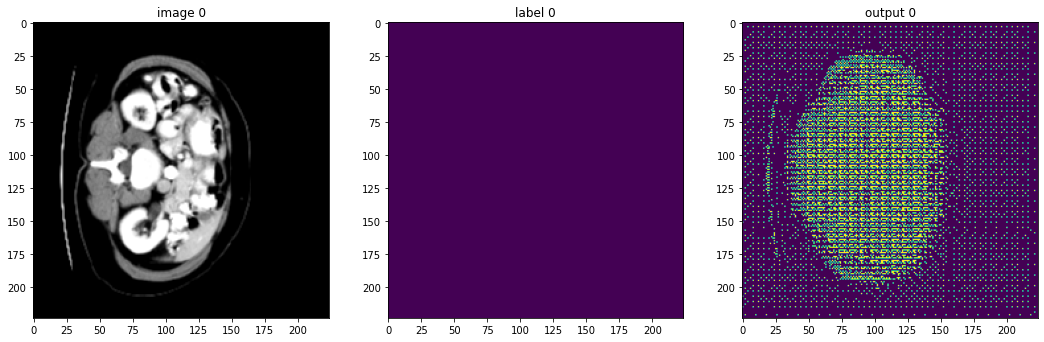

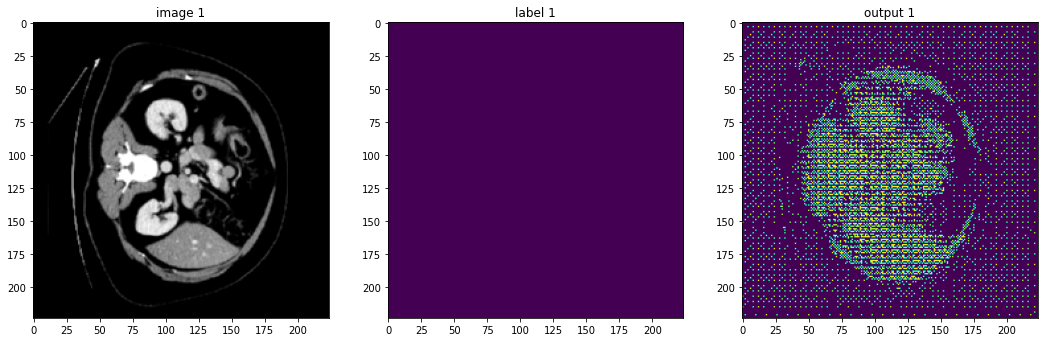

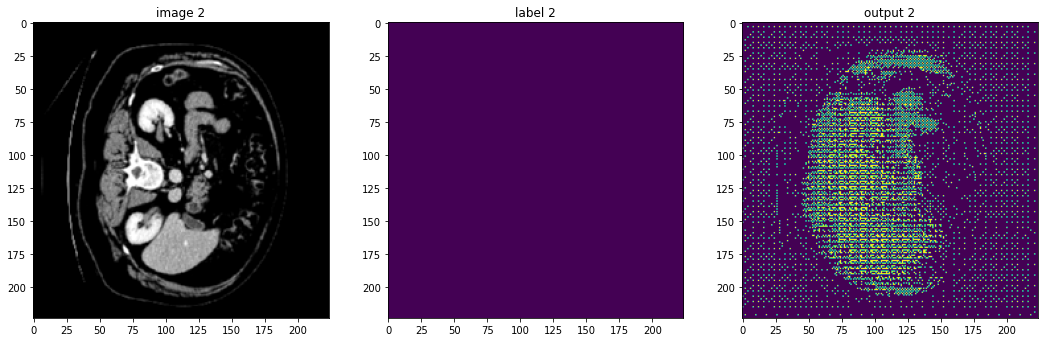

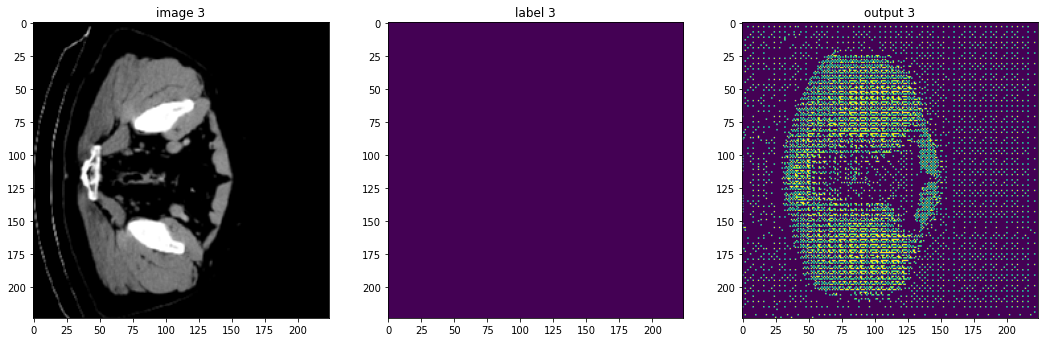

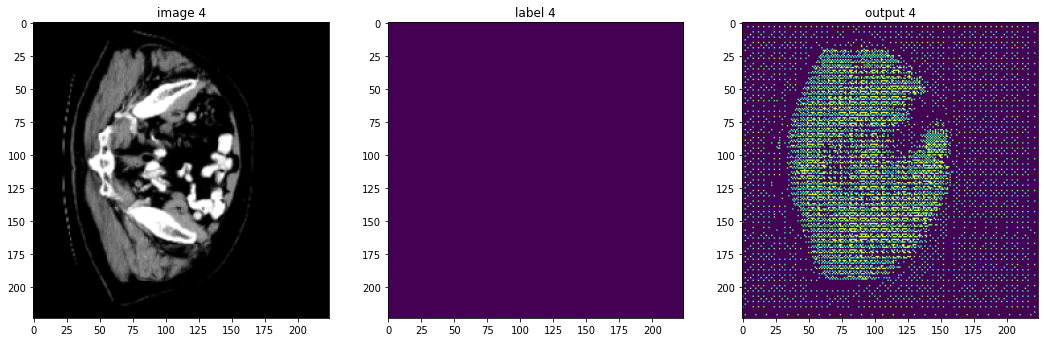

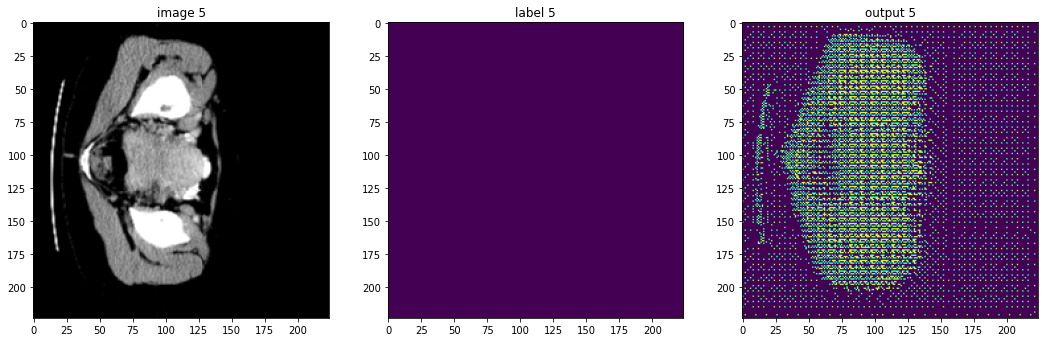

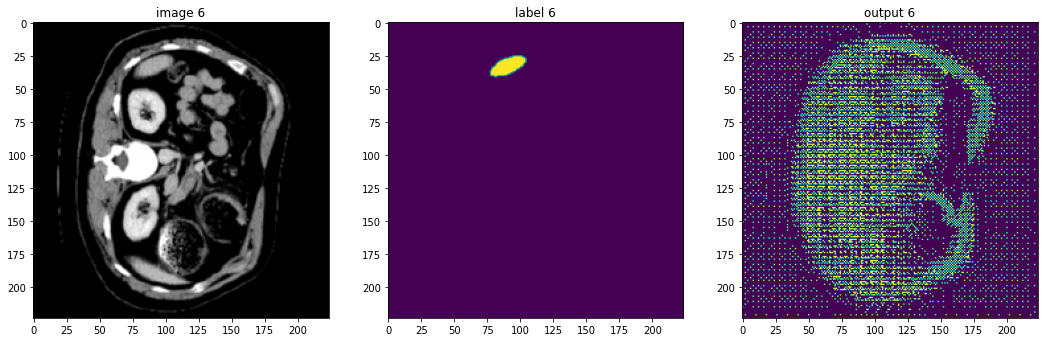

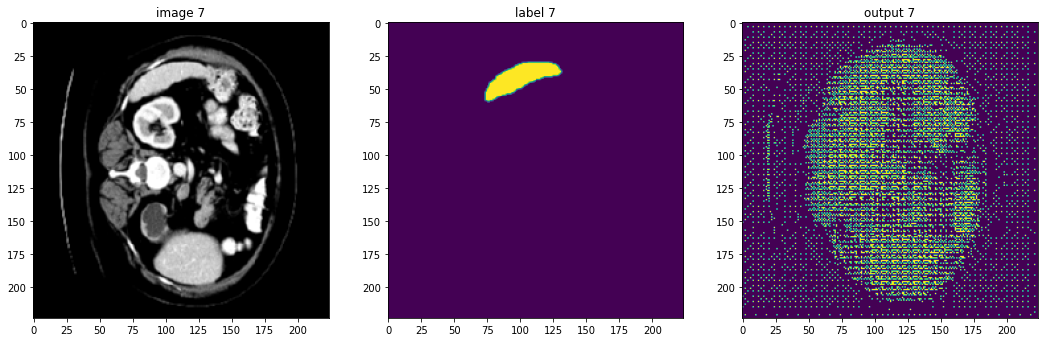

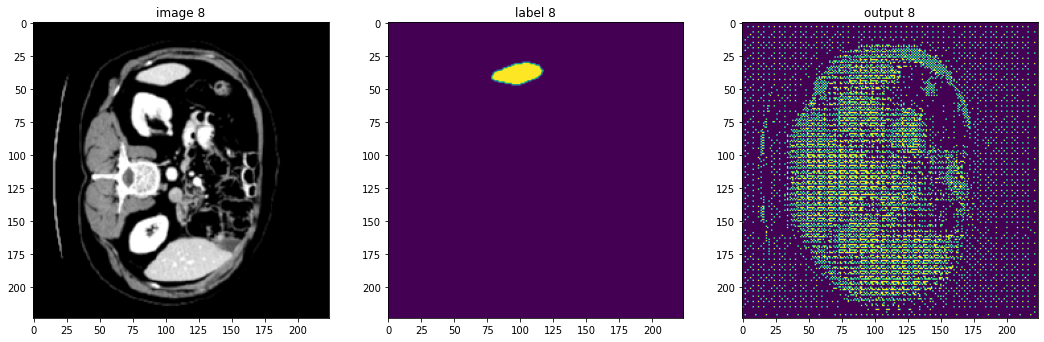

In [17]:
import matplotlib.pyplot as plt
model.eval()
device = torch.device("cuda:0")
model.to(device)
val_shapes=[]
with torch.no_grad():
    for i, val_data in enumerate(model.val_dataloader()):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        val_shapes.append(val_data["image"].shape)

In [18]:
val_shapes#predicted

[torch.Size([1, 1, 224, 224, 192]),
 torch.Size([1, 1, 224, 224, 192]),
 torch.Size([1, 1, 224, 224, 192]),
 torch.Size([1, 1, 224, 224, 288]),
 torch.Size([1, 1, 224, 224, 288]),
 torch.Size([1, 1, 224, 224, 288]),
 torch.Size([1, 1, 224, 224, 192]),
 torch.Size([1, 1, 224, 224, 192]),
 torch.Size([1, 1, 224, 224, 192])]

In [20]:
val_label_shape

[(512, 512, 33),
 (512, 512, 50),
 (512, 512, 135),
 (512, 512, 97),
 (512, 512, 101),
 (512, 512, 80),
 (512, 512, 60),
 (512, 512, 31),
 (512, 512, 41)]